# Car damage case

In [1]:
# Import packages
import os
import sys
import json
import random
import numpy as np
from mrcnn import utils
from mrcnn import visualize
from mrcnn.model import log
import mrcnn.model as modellib 
import dataset_utils
from mrcnn.config import Config
import imgaug
%matplotlib inline

Using TensorFlow backend.


In [2]:
from mrcnn.cocoapi.PythonAPI.pycocotools.coco import COCO
from mrcnn.cocoapi.PythonAPI.pycocotools.cocoeval import COCOeval
from mrcnn.cocoapi.PythonAPI.pycocotools import mask as maskUtils

# Worked after running: 
# cd coco/PythonAPI
# make
# sudo make install
# sudo python setup.py install

## Model overview
Overview of assumptions, choices, and limitations.

#### Pre-processing
- Split the training dataset into 90% train and 10% validation sets
- Use image augmentation. Currently only horizontal flipping is used.


#### Model and training
- Tuning parameters
- Trained model with Adam optimizer for x epochs

#### Post-processing



## Data import

#### Setting up root directory, data path  

In [3]:
ROOT_DIR = os.getcwd()
sys.path.append(ROOT_DIR)  

# Directory to save images
DATA_PATH = os.path.join(ROOT_DIR, "data/images/")

# Directory to save logs
MODEL_DIR = os.path.join(ROOT_DIR, "logs/")

# Pretrained model
PRETRAINED_MODEL_PATH = os.path.join(ROOT_DIR, "data/" "mask_rcnn_coco.h5")

#### Dataset loading and split
For training purpose we split the training set in training and evaluation. For training we use image 1 to 45, and for validation 46 to 50.

In [22]:
def print_info(dataset: dataset_utils.CustomDataset) -> None:
    """ Prints dataset info. """
    print("Image Count train: {}".format(len(dataset.image_ids)))
    print("Class Count train: {}".format(dataset.num_classes))
    for i, info in enumerate(dataset.class_info):
        print("{:3}. {:50} ".format(i, info['name']))
    

# Training data
dataset_train = dataset_utils.CustomDataset()
dataset_train.load_custom(DATA_PATH, "train")
dataset_train.prepare()
print_info(dataset=dataset_train)

# Validation data 
dataset_val = dataset_utils.CustomDataset()
dataset_val.load_custom(DATA_PATH, "val")
dataset_val.prepare()
print_info(dataset=dataset_val)

Image Count train: 44
Class Count train: 2
  0. BG                                                 
  1. scratch                                            
Image Count train: 5
Class Count train: 2
  0. BG                                                 
  1. scratch                                            


#### Image visualisation

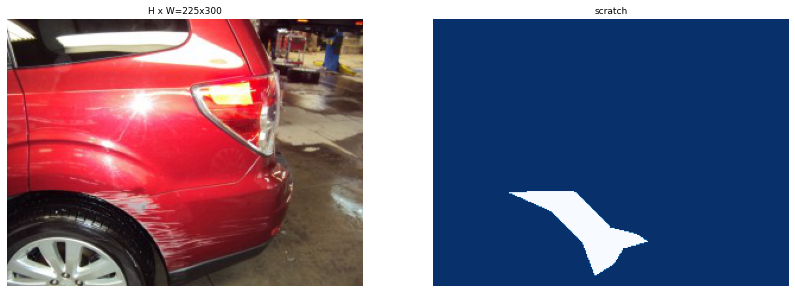

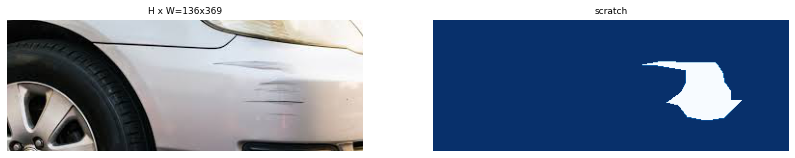

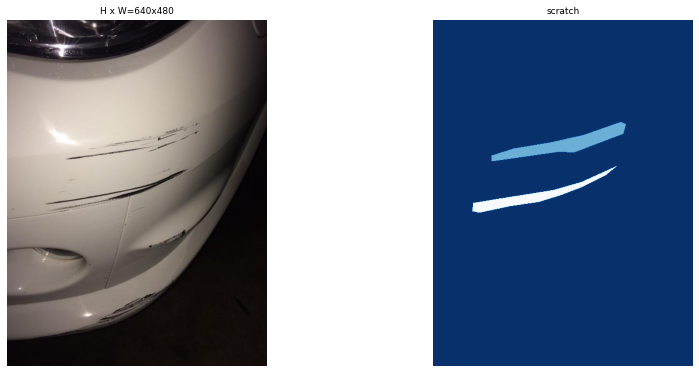

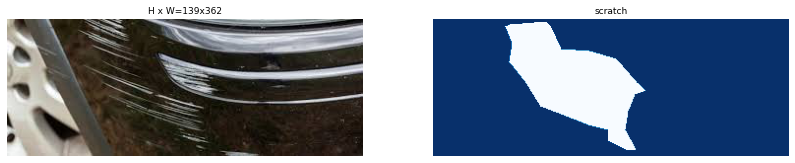

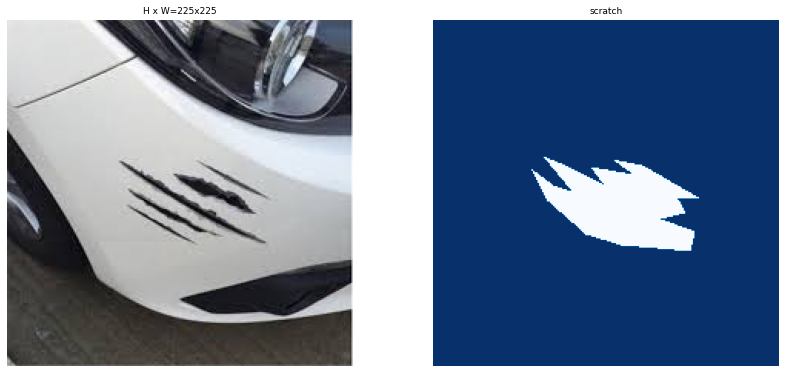

In [24]:
image_ids = np.random.choice(dataset.image_ids, 5)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names, limit=1)

#### Create Bounding Box(BB)with annotated damage mask for a typical car image.

image_id  35 /Users/jelmerkeuzenkamp/scm/damage_detection/data/images/train/image38.jpg
image                    shape: (599, 900, 3)         min:    0.00000  max:  255.00000  uint8
mask                     shape: (599, 900, 3)         min:    0.00000  max:    1.00000  bool
class_ids                shape: (3,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (3, 4)                min:  116.00000  max:  797.00000  int32


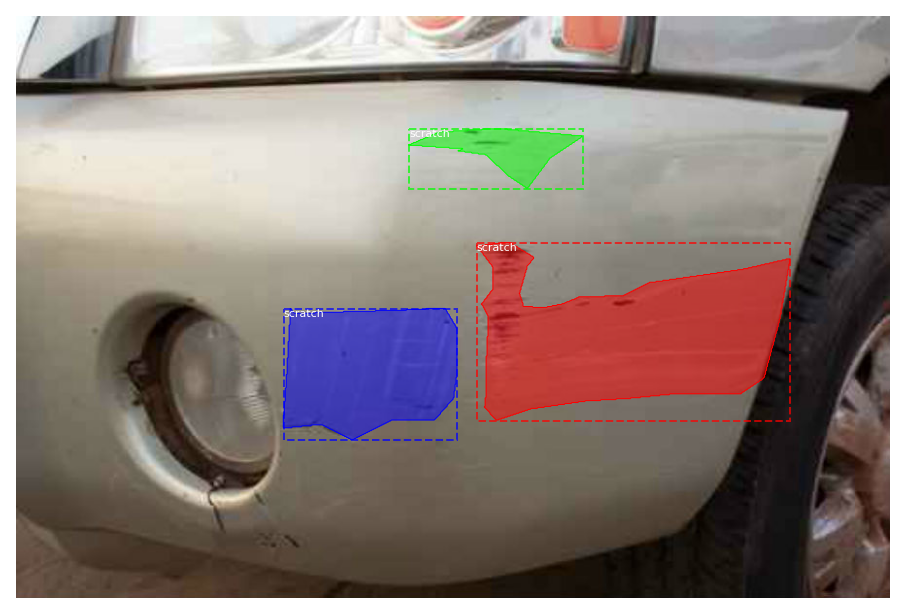

In [25]:
image_id = random.choice(dataset_train.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset_train.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset_train.class_names)

#### Damage polygon coordinates

In [26]:
anno_json = json.load(open(os.path.join(DATA_PATH, "train/via_region_data.json"),encoding="utf8"))
annotations = list(anno_json.values()) 
annotations = [a for a in annotations if a['regions']]

annotations[1]['regions']['0']['shape_attributes']
l = []
for d in annotations[1]['regions']['0']['shape_attributes'].values():
    l.append(d)
display('x co-ordinates of the damage:',l[1])    
display('y co-ordinates of the damage:',l[2])

'x co-ordinates of the damage:'

[293, 360, 349, 308, 293]

'y co-ordinates of the damage:'

[303, 330, 314, 302, 303]

## Model

#### Model configurations
Set and observe model configurations for training.

In [8]:
class DamageConfig(Config):
    """ Override base configerations for properties that need to be changed. """
    
    # Give the configuration a recognizable name
    NAME = "damage_detection"
    
    # Set number of classes 
    NUM_CLASSES = 2 # Background + scatch
    
    # Use small epoch for fast training
    STEPS_PER_EPOCH = 100
    
    # Use small images for faster training
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128
    
    # Use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
    # Train on 1 GPU and batch size is 2 (GPUs * images/GPU)
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2

config = DamageConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

#### Instantiate model
For training I used a instance on GCP's compute engine with 1 GPU and 12 GBs of memory.

In [9]:
model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [10]:
# Load pretrained weights
model_path = PRETRAINED_MODEL_PATH
# Load weights trained on MS COCO, but skip layers that
# are different due to the different number of classes
model.load_weights(model_path, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])

## Training

In [ ]:
# TODO: make training and validation sets 

In [ ]:
# Apply horizontal flipping for image augmentation
augmentation = imgaug.augmenters.Fliplr(0.5)

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads',
            augmentation=augmentation)